In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [11]:
# Load the metadata
metadata_path = "Data_Entry_2017_v2020.csv"
metadata = pd.read_csv(metadata_path).iloc[:10000]

# Check the first few rows
print(metadata.head())

# Define the diseases to classify
# diseases_to_classify = ["Pneumonia", "Atelectasis", "No_Finding", "Infiltration", "Effusion"]
diseases_to_classify = ["Pneumonia", "Atelectasis", "No Finding"]


# Create a Target column with only 3 classes
def map_disease(label):
    for i, disease in enumerate(diseases_to_classify):
        if disease in label:
            return i  # Assign index based on diseases_to_classify
    return -1  # Exclude other labels

metadata['Target'] = metadata['Finding Labels'].apply(map_disease)

# # Filter out rows with excluded labels
metadata = metadata[metadata['Target'] != -1]


# Check class distribution
print(metadata['Target'].value_counts())



        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                       

In [12]:
print(metadata['Finding Labels'].value_counts()) 
print(metadata[metadata['Finding Labels'] == 'No Finding'].shape[0])  
no_finding_count = metadata[metadata['Finding Labels'] == 'No Finding'].shape[0]
print(f"Number of 'No Finding' cases: {no_finding_count}")


Finding Labels
No Finding                                                     5709
Atelectasis                                                     367
Atelectasis|Infiltration                                        113
Atelectasis|Effusion                                             74
Atelectasis|Effusion|Infiltration                                41
                                                               ... 
Cardiomegaly|Pneumonia                                            1
Atelectasis|Edema|Effusion|Infiltration|Pneumonia                 1
Atelectasis|Edema|Effusion                                        1
Atelectasis|Consolidation|Edema|Effusion|Pleural_Thickening       1
Atelectasis|Nodule|Pneumonia                                      1
Name: count, Length: 117, dtype: int64
5709
Number of 'No Finding' cases: 5709


In [13]:
# Split into train, validation, and test sets
train_df, temp_df = train_test_split(metadata, test_size=0.2, stratify=metadata['Target'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Target'], random_state=42)

# print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
# print(f"Train DataFrame size: {train_df.shape}")
# print(f"Validation DataFrame size: {val_df.shape}")
# print(train_df.head())

# Custom Data Generator Class
class MyCustomDataset(Sequence):
    def __init__(self, dataframe, directory, batch_size, target_size, classes, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor
        self.dataframe = dataframe
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.classes = classes
        self.dataframe['Target'] = self.dataframe['Target'].astype(int)

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_df = self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        targets = []

        for _, row in batch_df.iterrows():
            image_path = f"{self.directory}/{row['Image Index']}"
            img = tf.keras.utils.load_img(image_path, target_size=self.target_size)
            img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
            targets.append(tf.keras.utils.to_categorical(row['Target'], num_classes=len(self.classes)))

        return np.array(images), np.array(targets)



# Convert Target column to categorical
metadata['Target'] = metadata['Target'].astype(int)
train_df, temp_df = train_test_split(metadata, test_size=0.2, stratify=metadata['Target'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Target'], random_state=42)

train_df['Target'] = train_df['Target'].astype(str)  # Generators require strings
val_df['Target'] = val_df['Target'].astype(str)
test_df['Target'] = test_df['Target'].astype(str)

# Define directories
# Create train and validation generators
image_dir = "Images/Images"
batch_size = 32
target_size = (224, 224)

# Image augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = MyCustomDataset(
    dataframe=train_df,
    directory=image_dir,
    batch_size=batch_size,
    target_size=target_size,
    classes=diseases_to_classify
)

val_generator = MyCustomDataset(
    dataframe=val_df,
    directory=image_dir,
    batch_size=batch_size,
    target_size=target_size,
    classes=diseases_to_classify
)

Train: 5364, Validation: 671, Test: 671
Train DataFrame size: (5364, 12)
Validation DataFrame size: (671, 12)
           Image Index        Finding Labels  Follow-up #  Patient ID  \
9464  00002457_005.png            No Finding            5        2457   
7271  00001921_006.png            No Finding            6        1921   
7130  00001891_000.png  Atelectasis|Fibrosis            0        1891   
9547  00002480_004.png            No Finding            4        2480   
4438  00001203_014.png            No Finding            9        1203   

      Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
9464           14              M            AP                 2048     2500   
7271           40              M            AP                 2500     2048   
7130           68              F            PA                 2048     2500   
9547           55              M            PA                 2500     2048   
4438           52              M            PA     

In [14]:
print(test_df['Target'].value_counts())


Target
2    571
1     86
0     14
Name: count, dtype: int64


In [15]:
# Check class distribution
# print(metadata['Target'].value_counts())

# Optional: Remove very rare classes or oversample rare classes
rare_classes = metadata['Target'].value_counts()[metadata['Target'].value_counts() < 5]
# print(f"Rare classes: {rare_classes}")
metadata = metadata[~metadata['Target'].isin(rare_classes.index)]


Target
2    5709
1     862
0     135
Name: count, dtype: int64
Rare classes: Series([], Name: count, dtype: int64)


In [16]:
# Model definition
# Load EfficientNetB0
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add classification layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(len(diseases_to_classify), activation='softmax')(x)

# Create and compile the model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [17]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2807s 16s/step - accuracy: 0.8321 - loss: 0.6782 - val_accuracy: 0.8510 - val_loss: 0.8066
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2678s 16s/step - accuracy: 0.8496 - loss: 0.4619 - val_accuracy: 0.8510 - val_loss: 0.5527
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2739s 16s/step - accuracy: 0.8497 - loss: 0.4297 - val_accuracy: 0.8510 - val_loss: 0.7407
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2720s 16s/step - accuracy: 0.8453 - loss: 0.4409 - val_accuracy: 0.8510 - val_loss: 0.6410
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2731s 16s/step - accuracy: 0.8490 - loss: 0.4182 - val_accuracy: 0.8510 - val_loss: 1.2238
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2726s 16s/step - accuracy: 0.8548 - loss: 0.4085 - val_accuracy: 0.8510 - val_loss: 0.4459
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2050s 12s/step - accuracy: 0.8481 - loss: 0.3980 - val_accuracy: 0.8510 - val_loss: 0.4759
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1481s 9s/step - accuracy: 0.8486 - loss: 0.

In [8]:
model.save('ResNet50.h5')

In [18]:
test_generator = MyCustomDataset(
    dataframe=test_df,
    directory=image_dir,
    batch_size=32,
    target_size=(224, 224),
    classes=diseases_to_classify
)


In [19]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred_classes:", np.unique(y_pred_classes))
print("Diseases to classify:", diseases_to_classify)


NameError: name 'y_true' is not defined

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8342 - loss: 0.5226
Test Loss: 0.5198
Test Accuracy: 0.8405


In [21]:
y_pred_probs = model.predict(test_generator)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

# True labels
y_true = test_df['Target'].astype(int).values  # Extract true labels from test_df


21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


In [22]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8405


In [24]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred_classes, average='weighted')  # Weighted for imbalanced data
print(f"F1-Score: {f1:.4f}")

F1-Score: 0.7772


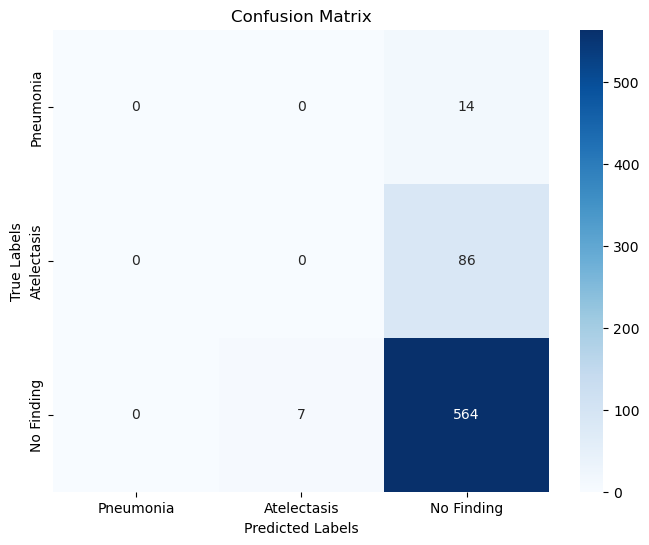

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(
    y_true, 
    y_pred_classes, 
    labels=range(len(diseases_to_classify))  # Ensures all classes (0, 1, 2) are included
)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=diseases_to_classify, yticklabels=diseases_to_classify)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()